**Construction of a basic Algo trading strategy - Buy low, sell high with fixed threshold parameters.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf

In [5]:
#First day 
start_date = '2014-01-01'
#Last day 
end_date = '2018-01-01'
#We call the function DataReader from the class data 
goog_data = yf.download('GOOG', start_date, end_date)

print(goog_data)
pd.set_option('display.width', 1000)

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG
Date                                                             
2014-01-02  27.517696  27.632156  27.397551  27.575545   73129082
2014-01-03  27.316959  27.611884  27.315229  27.564173   66917888
2014-01-06  27.621527  27.659596  27.352559  27.514978   71037271
2014-01-07  28.154018  28.174538  27.716455  27.811383  102486711
2014-01-08  28.212606  28.363159  28.016319  28.330527   90036218
...               ...        ...        ...        ...        ...
2017-12-22  52.611408  52.813888  52.577661  52.660539   15102000
2017-12-26  52.443668  52.611409  52.119099  52.509671   15212000
2017-12-27  52.077908  52.524558  52.012401  52.475923   25438000
2017-12-28  52.016861  52.344898  51.849613  52.188573   16742000
2017-12-29  51.930515  52.094288  51.856073  51.946395   17750000

[1007 rows x 5 columns]


In [6]:
goog_data_signal = pd.DataFrame(index = goog_data.index)
goog_data_signal['price'] = goog_data['Close']
goog_data_signal['daily_difference']= goog_data_signal['price'].diff()
print(goog_data_signal.head())

                price  daily_difference
Date                                   
2014-01-02  27.517696               NaN
2014-01-03  27.316959         -0.200737
2014-01-06  27.621527          0.304567
2014-01-07  28.154018          0.532492
2014-01-08  28.212606          0.058588


In [8]:
goog_data_signal['signal'] = 0.0
#reading the column we have 1 when we need to but and 0 when we need to sell
goog_data_signal['signal']= np.where(goog_data_signal['daily_difference']> 0, 1.0, 0.0)

print(goog_data_signal.head(10))

                price  daily_difference  signal
Date                                           
2014-01-02  27.517696               NaN     0.0
2014-01-03  27.316959         -0.200737     0.0
2014-01-06  27.621527          0.304567     1.0
2014-01-07  28.154018          0.532492     1.0
2014-01-08  28.212606          0.058588     1.0
2014-01-09  27.940924         -0.271683     0.0
2014-01-10  27.939440         -0.001484     0.0
2014-01-13  27.761448         -0.177992     0.0
2014-01-14  28.414581          0.653133     1.0
2014-01-15  28.395300         -0.019281     0.0


In [9]:
#we set up a limit in the number of orders and positions on the market
#in a purpose of simplification, i t is impossible to buy or sell
#more than one time consecutively 

goog_data_signal['positions']= goog_data_signal['signal'].diff()
print(goog_data_signal.head())


                price  daily_difference  signal  positions
Date                                                      
2014-01-02  27.517696               NaN     0.0        NaN
2014-01-03  27.316959         -0.200737     0.0        0.0
2014-01-06  27.621527          0.304567     1.0        1.0
2014-01-07  28.154018          0.532492     1.0        0.0
2014-01-08  28.212606          0.058588     1.0        0.0


**Plot of action done by the algo bot on a fixed historical period of time**

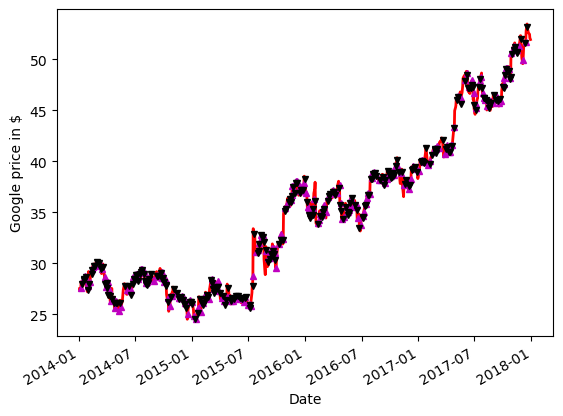

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel = 'Google price in $')
#plot of the range of days we initially chose
goog_data_signal['price'].plot(ax=ax1, color ='r', lw=2.)

#we draw an up arrow when we buy one share
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == 1.0].index,
         goog_data_signal.price[goog_data_signal.positions == 1.0],
         '^', markersize=5, color='m')

#we draw a down arrow when we sell one share
ax1.plot(goog_data_signal.loc[goog_data_signal.positions == -1.0].index,
         goog_data_signal.price[goog_data_signal.positions == -1.0],
         'v', markersize=5, color='k')

plt.show()

**Simple Backtest of the strategy and evaluation of the performance**

In [11]:
#==========================
#Backtesting -> intégration 
#==========================
#PnL 
#Net Profit (Net PnL --> includes fees)
#Exposure -> capital exposed (or nominal used)
#Number of trades
#Annualized returns 
#Sharpe ratio 

#construction of a portfolio w GOOG stocks and bonds
initial_capital = float(1000.0) #<- initial capital of 1,000.00 USD 
positions = pd.DataFrame(index = goog_data_signal.index).fillna(0.0)
portfolio = pd.DataFrame(index = goog_data_signal.index).fillna(0.0)

In [12]:
#storing positions 
positions['GOOG']= goog_data_signal['signal']

#storing of the amout of positions in the portfolio
portfolio['positions']= (positions.multiply(goog_data_signal['price'], axis=0))
#computation of the non-invested in stock money(cash)
portfolio['cash']= initial_capital - (positions.diff().multiply(goog_data_signal['price'], axis=0)).cumsum()
#total investment = position + cahs holdings 
portfolio['total']= portfolio['positions']+portfolio['cash']

In [14]:
portfolio.head(25)

,positions,cash,total
Date,,,
2014-01-02,0.000000,NaN,NaN
2014-01-03,0.000000,1000.000000,1000.000000
2014-01-06,27.621527,972.378473,1000.000000
2014-01-07,28.154018,972.378473,1000.532492
2014-01-08,28.212606,972.378473,1000.591080
2014-01-09,0.000000,1000.319397,1000.319397
2014-01-10,0.000000,1000.319397,1000.319397
2014-01-13,0.000000,1000.319397,1000.319397
2014-01-14,28.414581,971.904816,1000.319397


<Axes: xlabel='Date'>

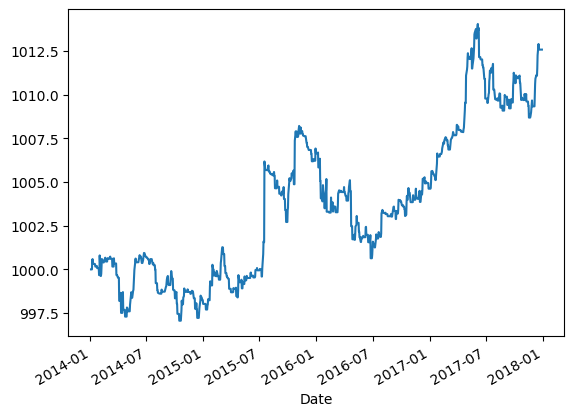

In [16]:
portfolio['total'].plot()